# Evaluate mock community classification accuracy
The purpose of this notebook is to evaluate taxonomic classification accuracy of mock communities using different classification methods.

Prepare the environment
-----------------------

First we'll import various functions that we'll need for generating the report. 

In [1]:
%matplotlib inline
from os.path import join, exists, expandvars
import pandas as pd
from IPython.display import display, Markdown
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           beta_diversity_pcoa,
                                           average_distance_boxplots,
                                           rank_optimized_method_performance_by_dataset)
from tax_credit.eval_framework import (evaluate_results,
                                       method_by_dataset_a1,
                                       method_by_dataset_a2,
                                       parameter_comparisons,
                                       merge_expected_and_observed_tables)

Configure local environment-specific values
-------------------------------------------

**This is the only cell that you will need to edit to generate basic reports locally.** After editing this cell, you can run all cells in this notebook to generate your analysis report. This will take a few minutes to run, as results are computed at multiple taxonomic levels.

Values in this cell will not need to be changed, with the exception of ``project_dir``, to generate the default results contained within tax-credit. To analyze results separately from the tax-credit precomputed results, other variables in this cell will need to be set.

In [2]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## short-read-tax-assignment repository. 
project_dir = expandvars("$HOME/Desktop/projects/short-read-tax-assignment")

## expected_results_dir contains expected composition data in the structure
## expected_results_dir/<dataset name>/<reference name>/expected/
expected_results_dir = join(project_dir, "data/precomputed-results/", "mock-community")

## mock_results_fp designates the files to which summary results are written.
## If this file exists, it can be read in to generate results plots, instead
## of computing new scores.
mock_results_fp = join(expected_results_dir, 'mock_results.tsv')

## results_dirs should contain the directory or directories where
## results can be found. By default, this is the same location as expected 
## results included with the project. If other results should be included, 
## absolute paths to those directories should be added to this list.
results_dirs = [expected_results_dir]

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

## Define the range of taxonomic levels over which to compute accuracy scores.
## The default given below will compute order (level 2) through species (level 6)
taxonomy_level_range = range(2,7)

Find mock community pre-computed tables, expected tables, and "query" tables
----------------------------------------------------------------------------

Next we'll use the paths defined above to find all of the tables that will be compared. These include the *pre-computed result* tables (i.e., the ones that the new methods will be compared to), the *expected result* tables (i.e., the tables containing the known composition of the mock microbial communities), and the *query result* tables (i.e., the tables generated with the new method(s) that we want to compare to the *pre-computed result* tables).

**Note**: if you have added additional methods and are attempting to recompute results, set force=True.

This cell will take a few minutes to run, so hold onto your hat.

In [3]:
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                taxonomy_level_range=range(2,7), 
                                min_count=min_count,
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                force=False)

/Users/nbokulich/Desktop/projects/short-read-tax-assignment/data/precomputed-results/mock-community/mock_results.tsv already exists.
Reading in pre-computed evaluation results.
To overwrite, set force=True


Restrict analyses to a set of datasets or references: e.g., exclude taxonomy assignments made for purpose of reference database comparisons.

In [4]:
mock_results = mock_results[mock_results['Reference'].isin(['gg_13_8_otus', 'unite_20.11.2016'])]

Evalution 1: Compute and summarize precision, recall, and F-measure for mock communities
----------------------------------------------------------------------------------------

In this evaluation, we compute and summarize precision, recall, and F-measure of each result (pre-computed and query) based on the known composition of the mock communities. We then summarize the results in two ways: first with boxplots, and second with a table of the top methods based on their F-measures. 

This is a qualitative evaluation, effectively telling us about the ability of the different methods to report the taxa that are present in each sample. These metrics are not concerned with the abundance of the different taxa.

As a first step, we will evaluate how accuracy metrics perform at each taxonomic level for each method within each reference dataset type.

In [5]:
color_pallette={'expected': 'red', 'rdp': 'seagreen', 'sortmerna': 'gray', 'uclust': 'blue', 'blast': 'purple'}

y_vars = ["Precision", "Recall", "F-measure"]

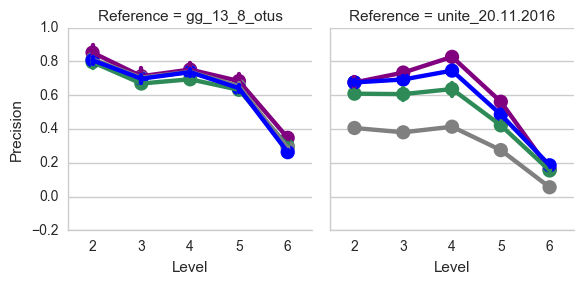

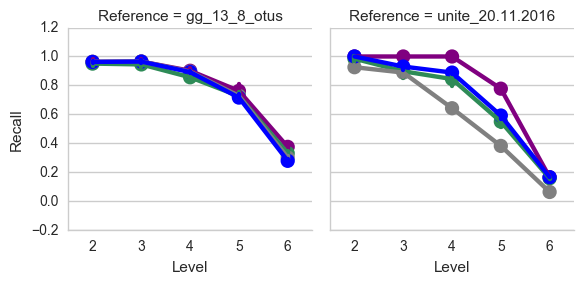

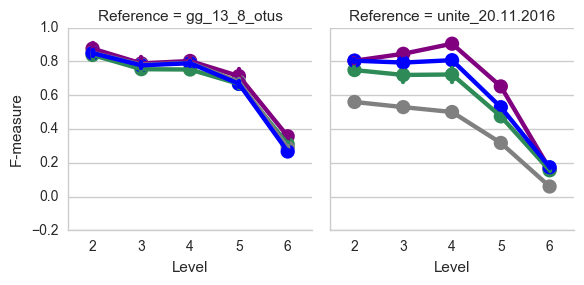

In [13]:
pointplot_from_data_frame(mock_results, "Level", y_vars, 
                          group_by="Reference", color_by="Method",
                          color_pallette=color_pallette)

### Kruskal-Wallis between-method accuracy comparisons
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [7]:
result = per_level_kruskal_wallis(mock_results, y_vars, group_by='Method', 
                                  dataset_col='Reference', level_name='Level',
                                  levelrange=range(2,7), alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Reference   Variable             2             3             4  \
0      gg_13_8_otus  Precision  2.182731e-03  5.825658e-02  2.237219e-04   
1      gg_13_8_otus     Recall  1.800433e-01  3.404256e-02  5.016869e-02   
2      gg_13_8_otus  F-measure  1.443550e-02  1.125500e-02  1.905841e-04   
3  unite_20.11.2016  Precision  5.987467e-59  6.726768e-57  1.281531e-54   
4  unite_20.11.2016     Recall  8.501679e-09  6.154355e-02  3.827549e-26   
5  unite_20.11.2016  F-measure  2.128950e-58  1.297096e-41  5.783875e-50   

              5             6  
0  6.253870e-02  6.931415e-08  
1  1.157283e-01  4.709892e-14  
2  8.788237e-02  9.436843e-14  
3  3.859014e-41  4.488010e-51  
4  2.434781e-24  2.191578e-39  
5  1.810539e-32  4.153603e-50

### Beta diversity method/parameter comparisons
Principal coordinate analysis offers a neat way to assess the relative performance of multiple methods to reconstruct expected compositions. Methods that cluster with the "expected" composition probably outperform those that appear more distant on a PCoA plot. First, we need to merge biom tables from each method/parameter configuration for each dataset/reference/level combination, so that we can compare each method/parameter as a separate "sample".

**Note**: if you have added additional methods and are attempting to recompute results, set force=True.


In [8]:
merge_expected_and_observed_tables(expected_results_dir, results_dirs, taxonomy_level=6, force=False)

Now we can manually select which table we want to view. This will output a Bray-Curtis PCoA plot, in addition to ANOSIM test results, which indicate whether at least two methods are significantly different from each other.

These plots are useful for visualizing the relative performance of different methods and their configurations relative to each other and to expected compositions, but are primarily a qualitative technique and do not really give us an idea of whether method X actually performs better than method Y.

*Note that 2D plots will only appear if you are running notebooks locally. If viewing static notebooks online, follow the link provided below.*

In [10]:
table = join(expected_results_dir, 'mock-9', 'unite_20.11.2016', 'merged_table.biom')
sample_md, results, pc, dm = beta_diversity_pcoa(table, method="braycurtis", dim=2,
                                                 permutations=99, col='method', 
                                                 colormap=color_pallette)

R =  0.26735271598 ; P =  0.01


/Users/nbokulich/miniconda3/envs/qiime2-06/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.4022195203912908 and the largest is 25.023985272790906.
  RuntimeWarning


View static file [here](../../data/precomputed-results/mock-community/mock-9/unite_20.11.2016/pcoa.html)

Loading BokehJS ...

You can also view all beta diversity plots with a single command, ``batch_beta_diversity()``, but we will only show single dataset examples in these example notebooks.

### Average distance between expected results and observed results for each method 


As we already discussed, PCoA plots are good for a qualitative overview, but don't offer much in the way of quantitative comparison. Instead, we can directly compare the Bray-Curtis dissimilarity between methods, and utilize pairwise Mann-Whitney U tests to determine precisely which methods perform better. In the cell below, we will use distance comparisons to determine:

    1) Whether the dissimilarity between taxonomic assignment with different parameters of the same method is greater or less than the dissimilarity between taxonomic assignments with different methods, including the expected composition.
    2) which method (averaged across all configurations) most closely reproduces the expected composition.
    
You can generate boxplots for individual datasets one-by-one with ``per_method_boxplots()``, or for all datasets individually with ``fastlane_boxplots()``. However, here we are most interested in the average performance of methods across each dataset.

The command below violin plots of distribution of distances between expected composition and predicted compositions for each method (all parameter configurations) across all samples/datasets, and pairwise Mann Whitney U tests between these distributions.

method A   method B             P
0      blast        rdp  4.801369e-06
1      blast  sortmerna  1.925793e-10
2      blast     uclust  1.632010e-06
3        rdp  sortmerna  5.961794e-02
4        rdp     uclust  4.154223e-01
5  sortmerna     uclust  2.213793e-01

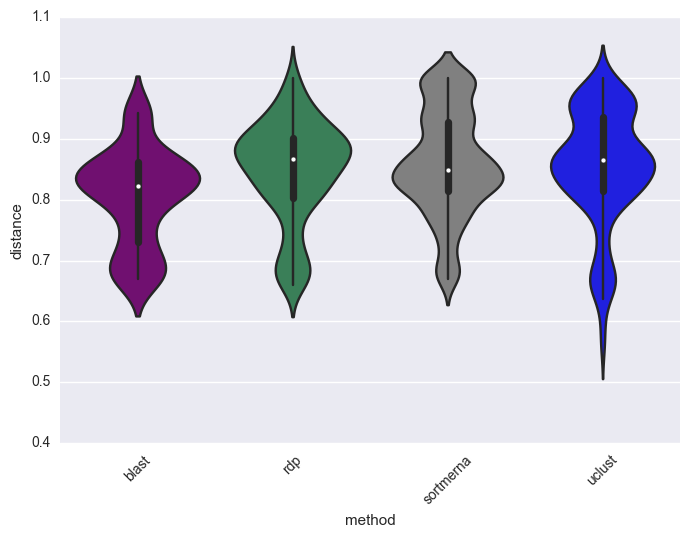

In [6]:
results = average_distance_boxplots(expected_results_dir, paired=False, use_best=False, color_pallette=color_pallette)
results

### Average distance between expected results and observed results for each method with optimized parameters 
Reports the top-performing parameter configuration for each method, violin plots of distribution of distances between expected composition and predicted compositions for the top parameter for each method across all samples/datasets, and pairwise paired Wilcoxon signed rank tests between these distributions.

method              params
0      blast               1e-10
1        rdp                 0.0
2  sortmerna  0.51:0.8:1:0.8:1.0
3     uclust          0.51:0.8:1

method A   method B         P
0      blast        rdp  0.294118
1      blast  sortmerna  0.065082
2      blast     uclust  0.851122
3        rdp  sortmerna  0.851122
4        rdp     uclust  0.851122
5  sortmerna     uclust  0.851122

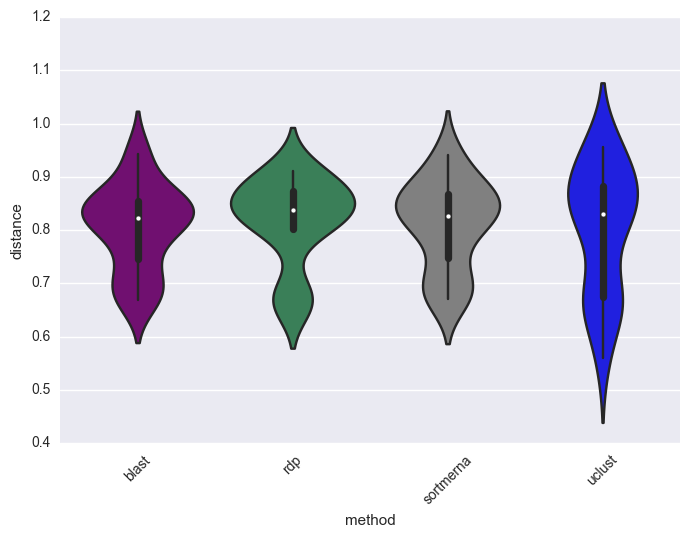

In [8]:
results = average_distance_boxplots(expected_results_dir, color_pallette=color_pallette)
results

### Heatmaps of per-level accuracy
Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database (i.e., for bacterial and fungal mock communities individually).

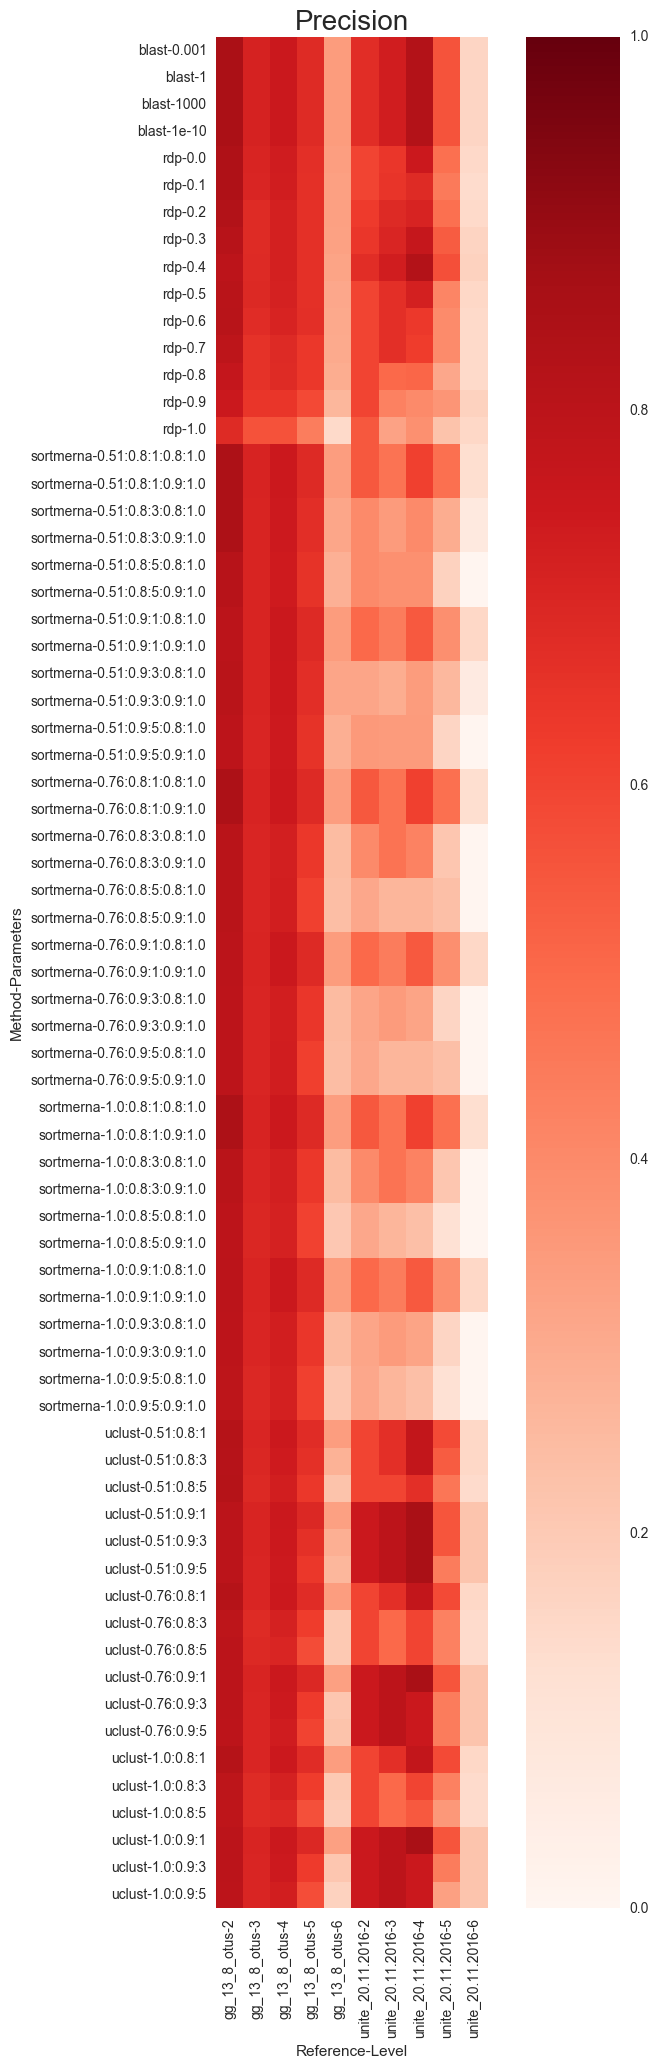

In [14]:
heatmap_from_data_frame(mock_results, metric="Precision", rows=["Method", "Parameters"], cols=["Reference", "Level"])

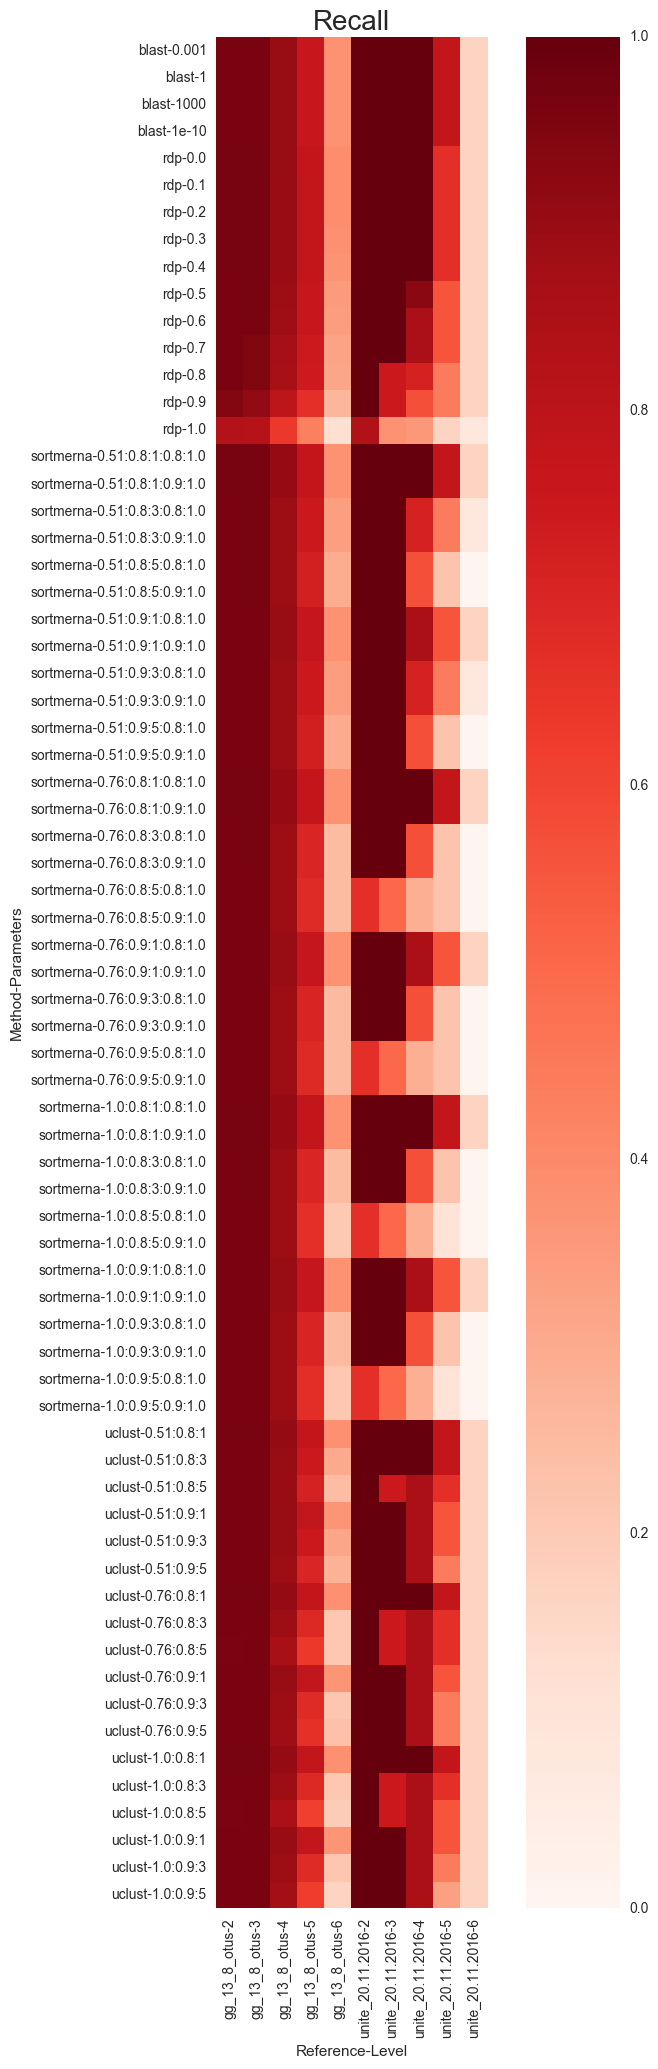

In [15]:
heatmap_from_data_frame(mock_results, metric="Recall", rows=["Method", "Parameters"], cols=["Reference", "Level"])

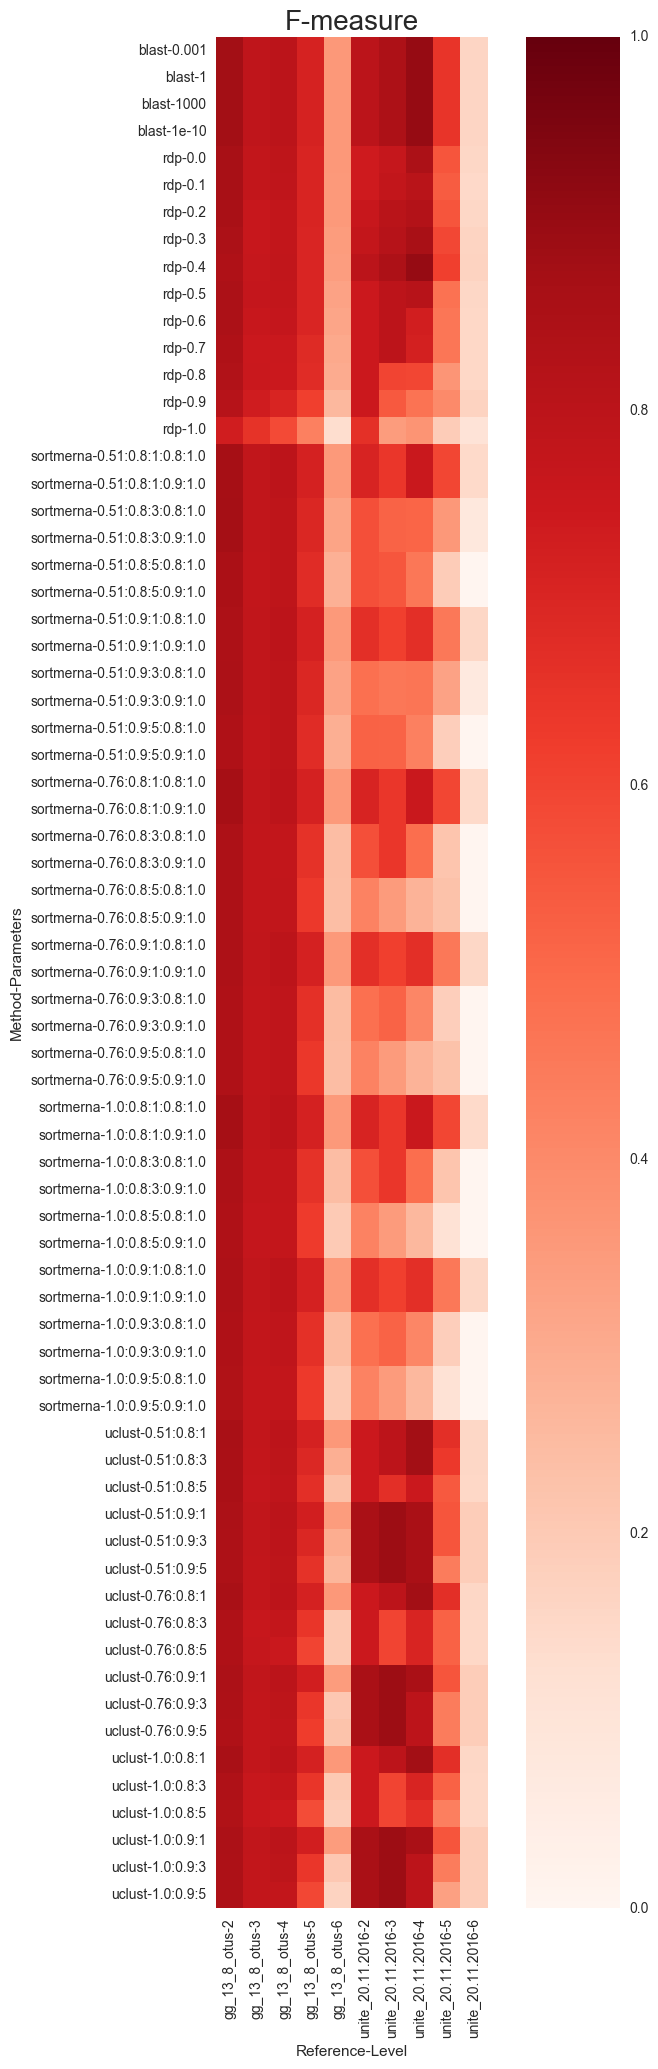

In [16]:
heatmap_from_data_frame(mock_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Reference", "Level"])

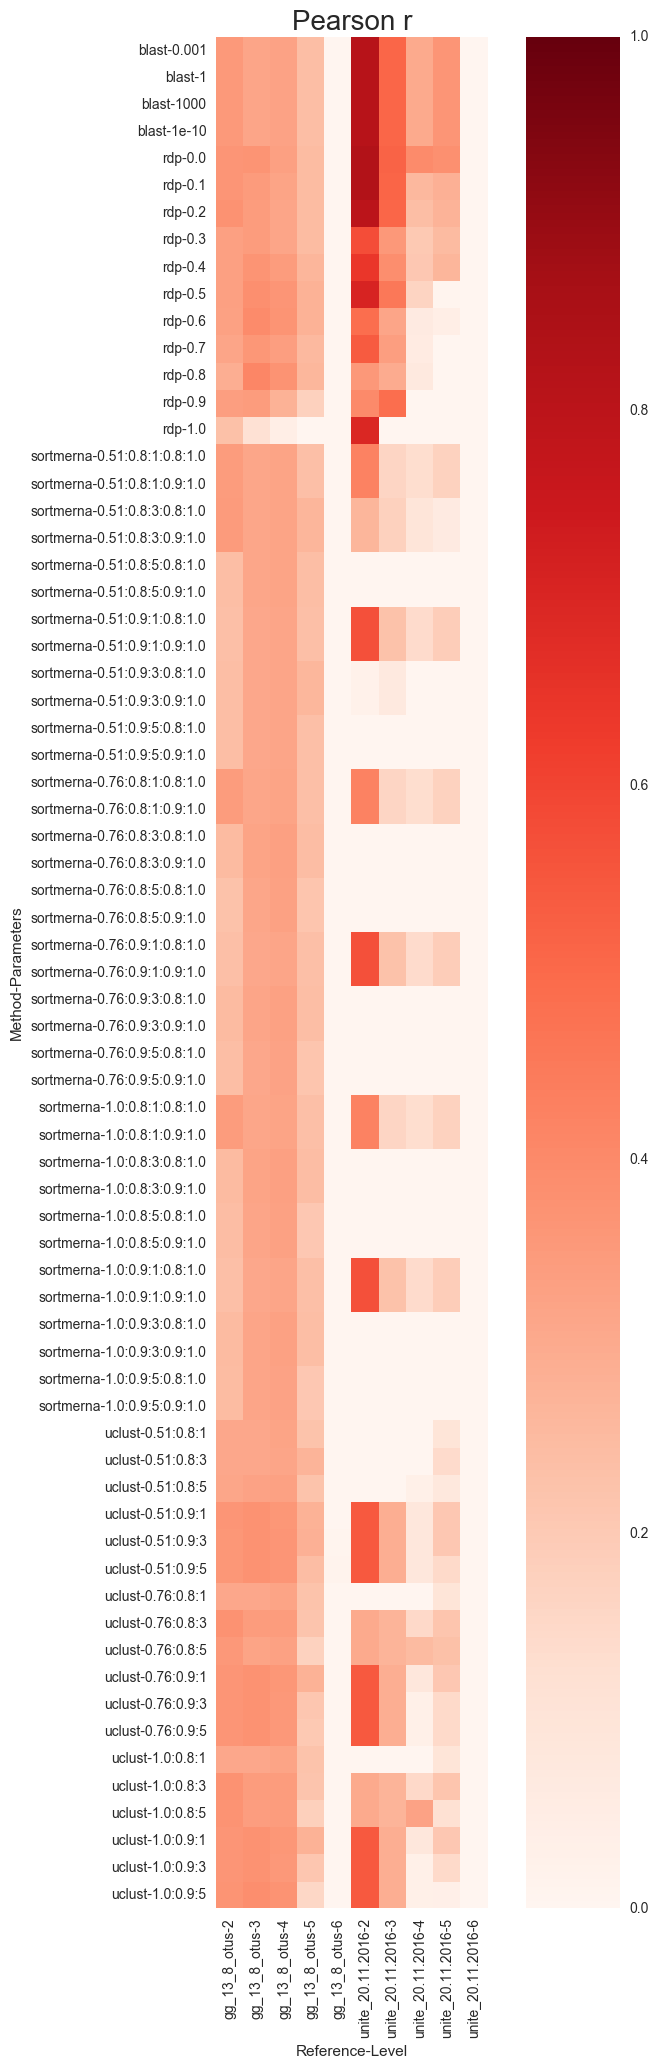

In [17]:
heatmap_from_data_frame(mock_results, metric="Pearson r", rows=["Method", "Parameters"], cols=["Reference", "Level"])

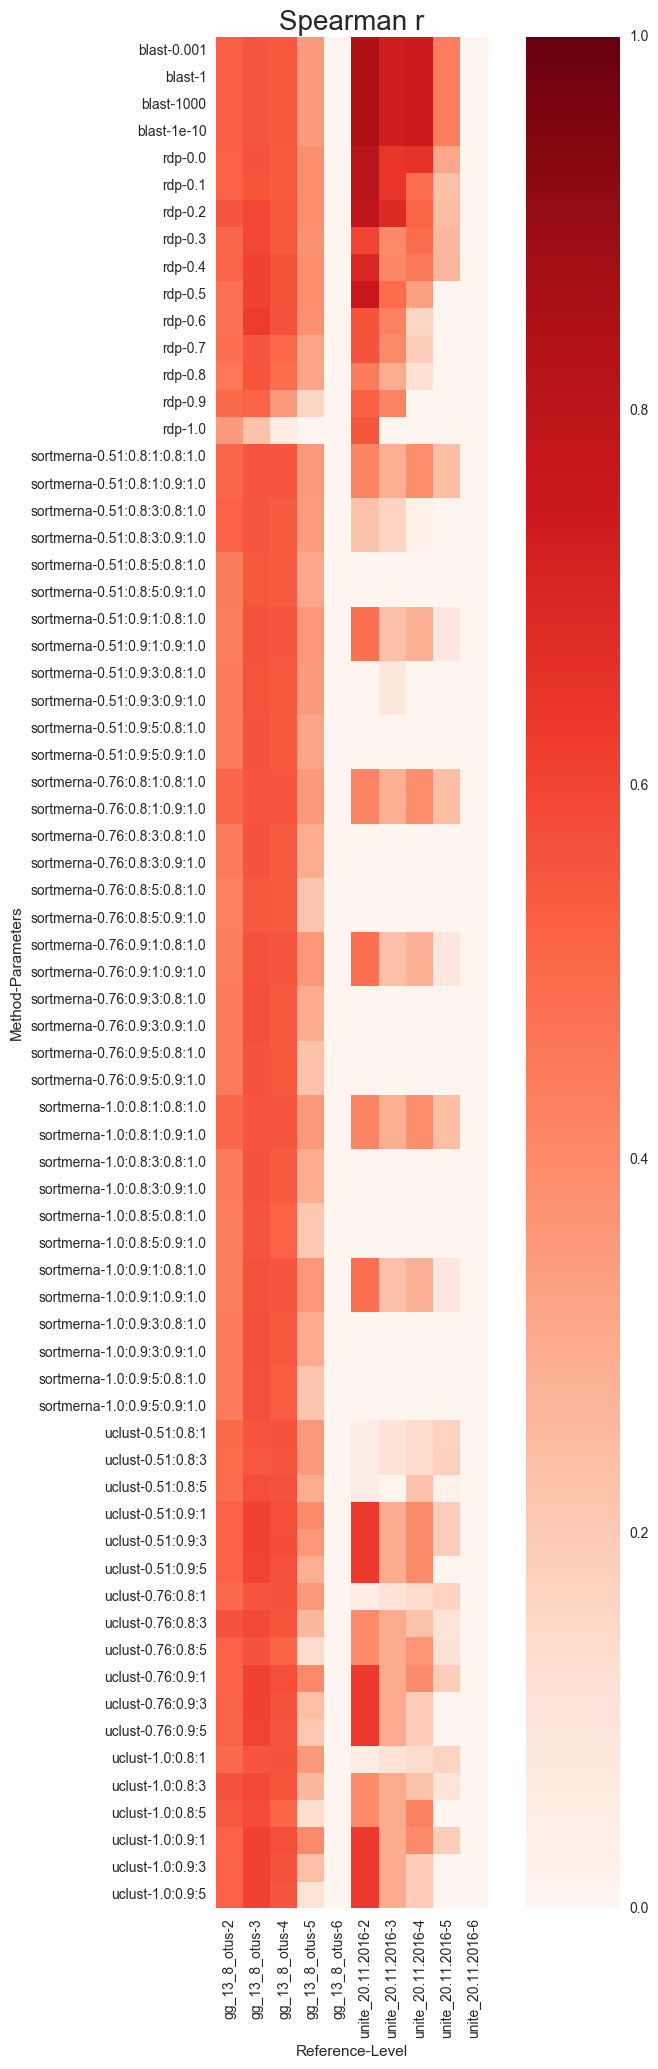

In [18]:
heatmap_from_data_frame(mock_results, metric="Spearman r", rows=["Method", "Parameters"], cols=["Reference", "Level"])

Now we will focus on results at species level (for genus level, change to level 5)

In [7]:
mock_results_6 = mock_results[mock_results['Level'] == 6]

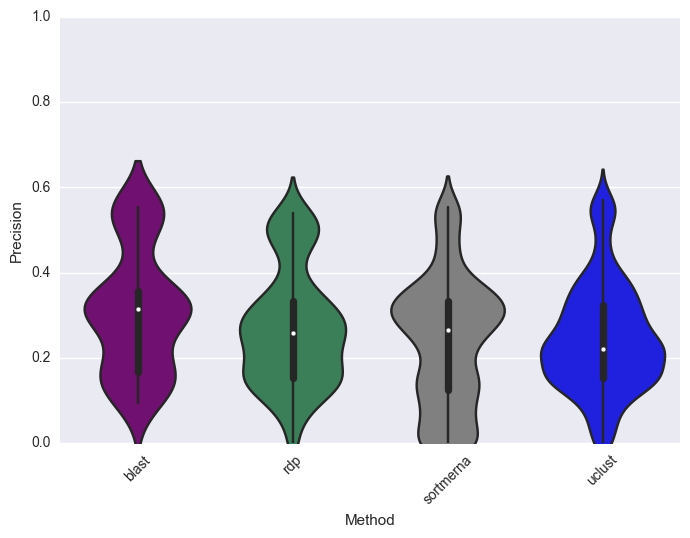

In [11]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Precision", color_pallette=color_pallette)

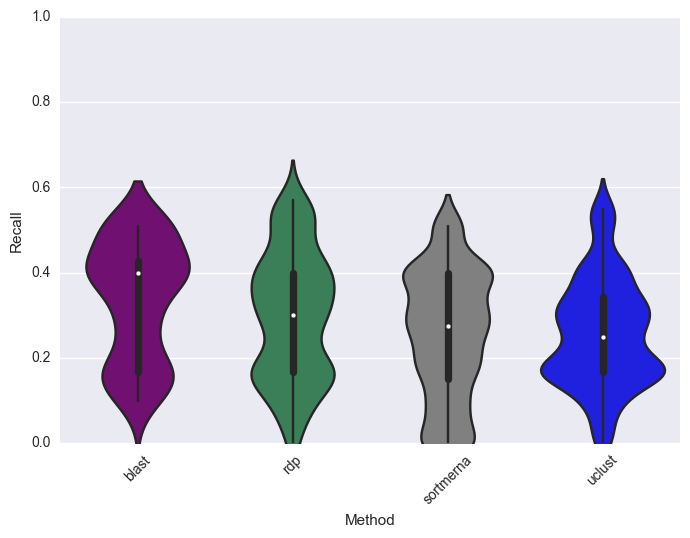

In [12]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Recall", color_pallette=color_pallette)

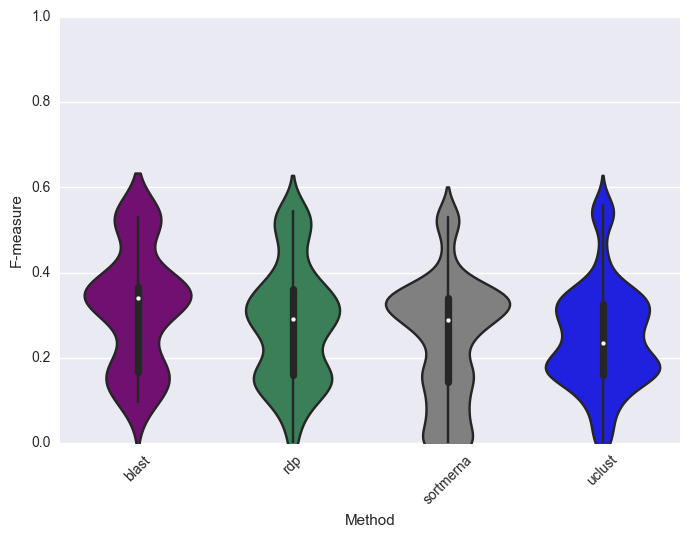

In [13]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="F-measure", color_pallette=color_pallette)

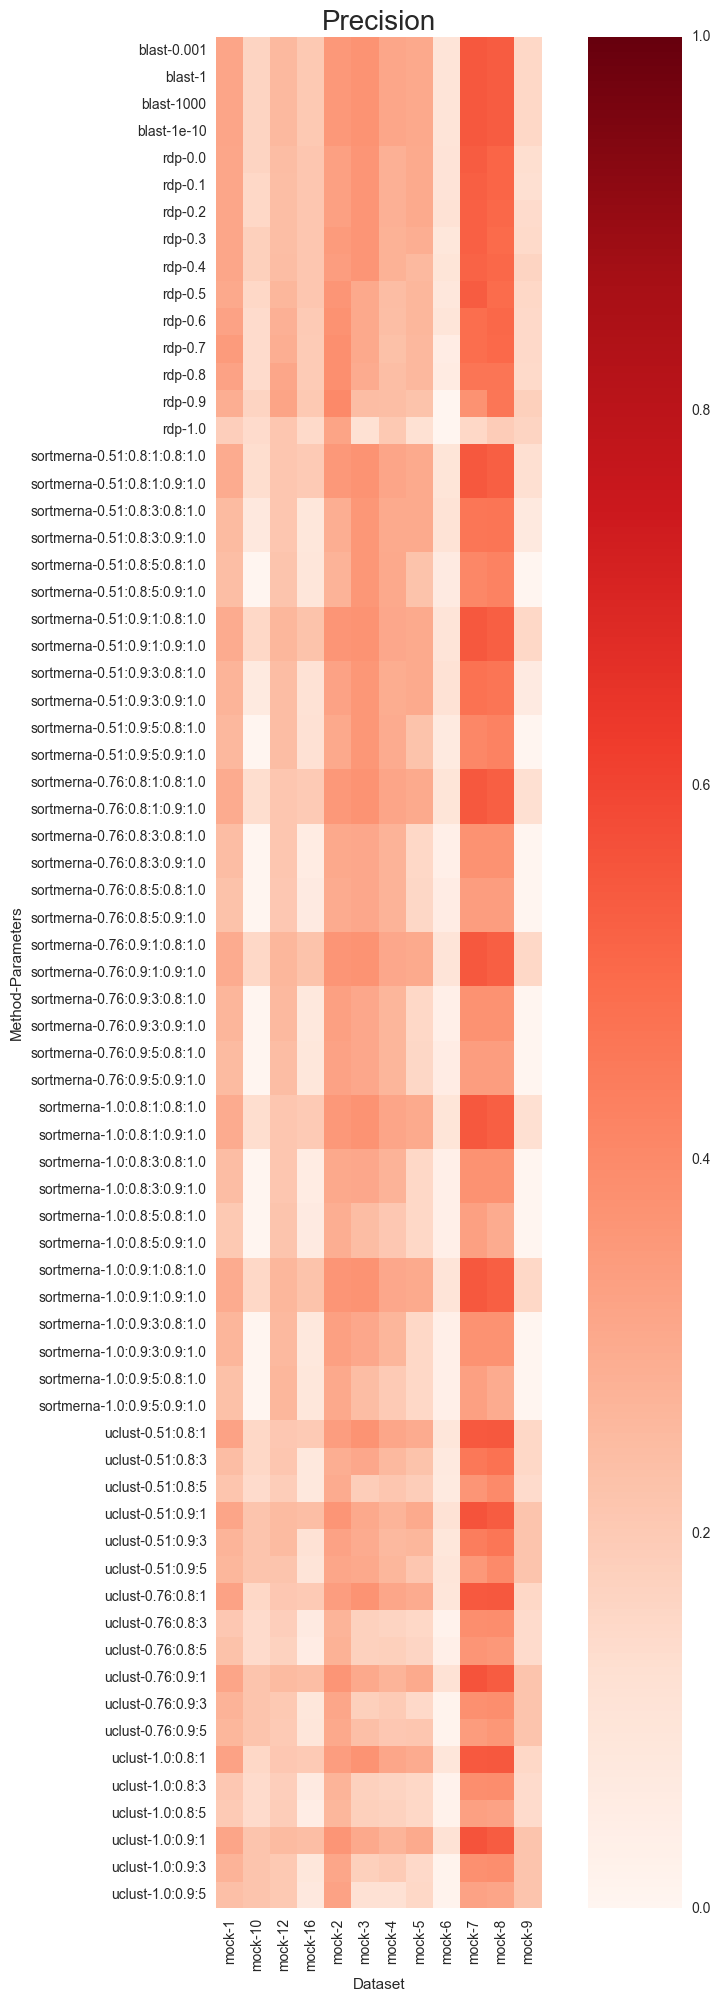

In [23]:
heatmap_from_data_frame(mock_results_6, "Precision")

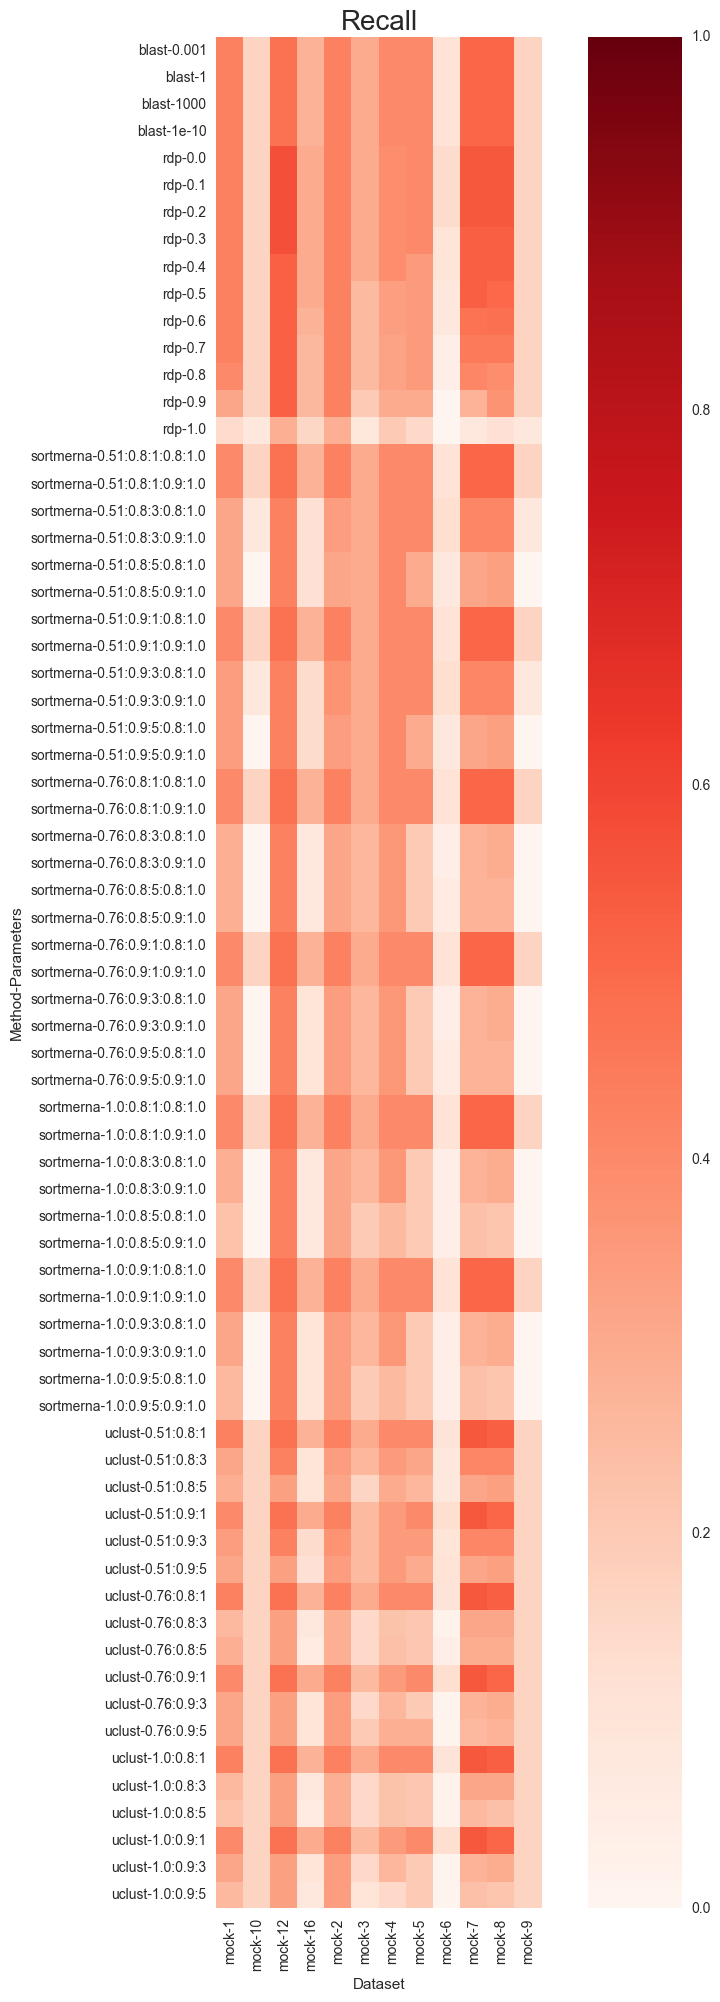

In [24]:
heatmap_from_data_frame(mock_results_6, "Recall")

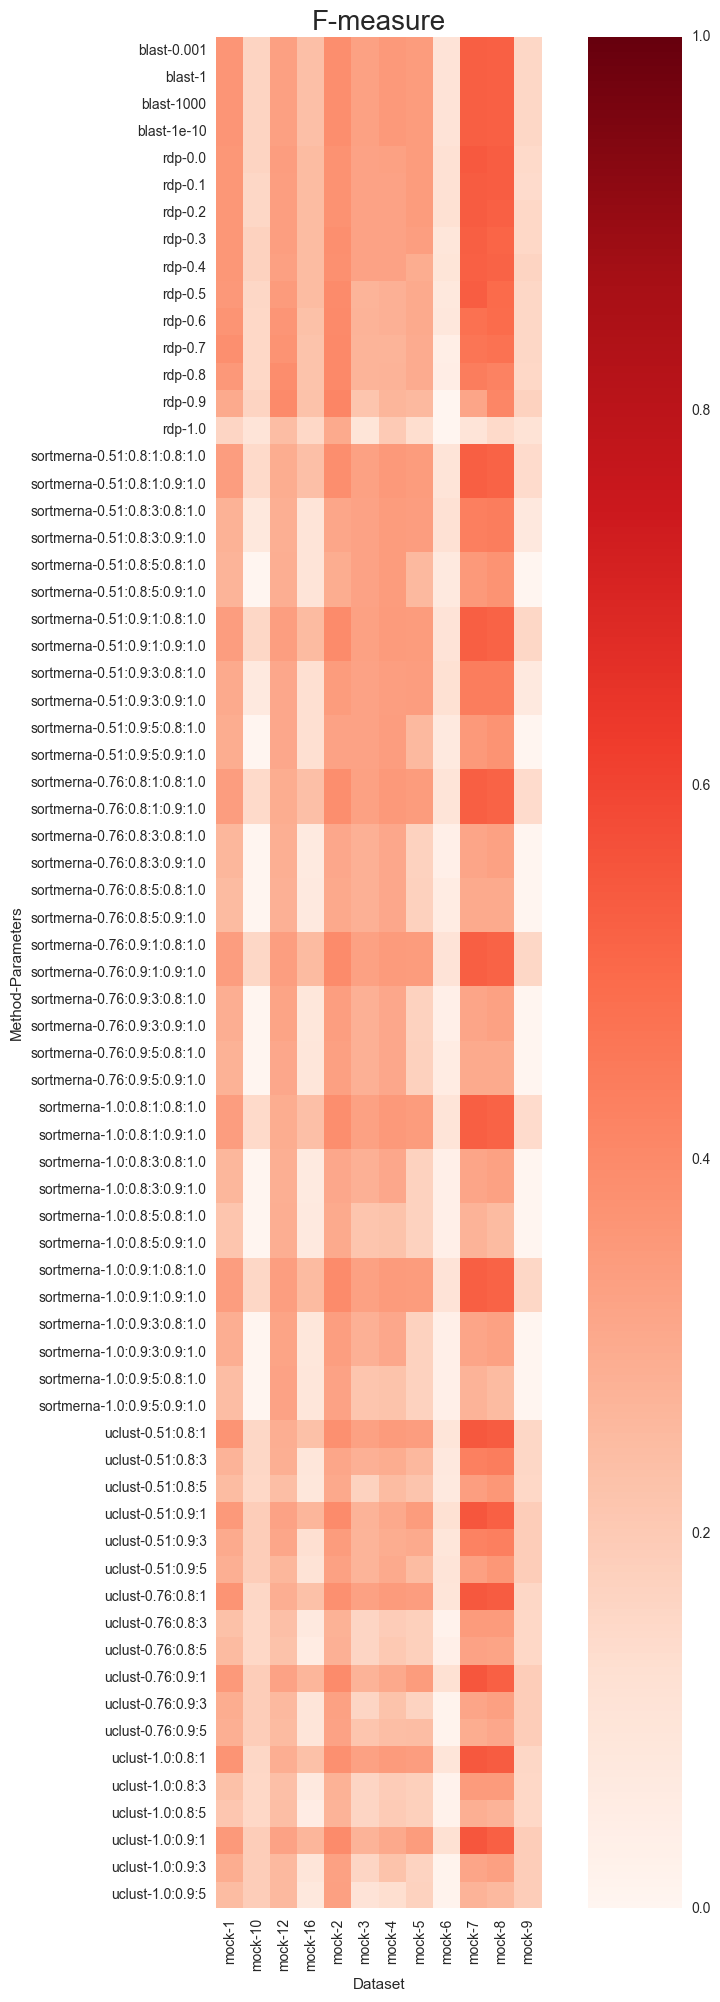

In [25]:
heatmap_from_data_frame(mock_results_6, "F-measure")

### Method Optimization
Which method/parameter configuration performed "best" for a given score? We can rank the top-performing configuration by dataset, method, and taxonomic level.

First, the top-performing method/configuration combination by dataset.

In [14]:
for i in [n for n in range(1,11)] + [12, 16]:
    display(Markdown('## mock-{0}'.format(i)))
    best = method_by_dataset_a1(mock_results_6, 'mock-{0}'.format(i))
    display(best)

## mock-1

Method         Parameters  Precision    Recall  F-measure
59         rdp                0.7   0.348837  0.428571   0.384615
289     uclust         0.76:0.8:1   0.326087  0.428571   0.370370
9        blast                  1   0.319149  0.428571   0.365854
234  sortmerna  1.0:0.9:1:0.9:1.0   0.297872  0.400000   0.341463

## mock-2

Method          Parameters  Precision    Recall  F-measure
3174        rdp                 0.9   0.405405  0.428571   0.416667
3279  sortmerna  0.76:0.9:1:0.9:1.0   0.365854  0.428571   0.394737
3379     uclust          0.51:0.9:1   0.365854  0.428571   0.394737
3114      blast                   1   0.357143  0.428571   0.389610

## mock-3

Method          Parameters  Precision  Recall  F-measure
4148  sortmerna  0.76:0.9:1:0.9:1.0   0.461538     0.3   0.363636
3608        rdp                 0.3   0.461538     0.3   0.363636
4488     uclust          0.51:0.8:1   0.461538     0.3   0.363636
3528      blast               1e-10   0.461538     0.3   0.363636

## mock-4

Method          Parameters  Precision  Recall  F-measure
5586  sortmerna  0.51:0.8:1:0.8:1.0   0.347826     0.4   0.372093
6547     uclust           1.0:0.8:1   0.333333     0.4   0.363636
5286      blast               0.001   0.333333     0.4   0.363636
5366        rdp                 0.0   0.307692     0.4   0.347826

## mock-5

Method          Parameters  Precision  Recall  F-measure
7207  sortmerna  0.76:0.8:1:0.8:1.0   0.333333     0.4   0.363636
6747        rdp                 0.0   0.333333     0.4   0.363636
7867     uclust          0.76:0.9:1   0.333333     0.4   0.363636
6667      blast               0.001   0.333333     0.4   0.363636

## mock-6

Method          Parameters  Precision    Recall  F-measure
8298  sortmerna  0.51:0.8:3:0.8:1.0   0.129630  0.137255   0.133333
9033     uclust           1.0:0.9:1   0.129630  0.137255   0.133333
8133        rdp                 0.2   0.125000  0.137255   0.130841
8043      blast               0.001   0.115385  0.117647   0.116505

## mock-7

Method         Parameters  Precision    Recall  F-measure
9977     uclust         0.76:0.9:1   0.571429  0.549020   0.560000
9138        rdp                0.0   0.538462  0.549020   0.543689
9662  sortmerna  1.0:0.8:1:0.8:1.0   0.553191  0.509804   0.530612
9077      blast              0.001   0.553191  0.509804   0.530612

## mock-8

Method          Parameters  Precision    Recall  F-measure
10967     uclust          0.76:0.8:1   0.562500  0.529412   0.545455
10187        rdp                 0.1   0.528302  0.549020   0.538462
10112      blast               0.001   0.553191  0.509804   0.530612
10352  sortmerna  0.51:0.8:1:0.9:1.0   0.541667  0.509804   0.525253

## mock-9

Method          Parameters  Precision    Recall  F-measure
12169     uclust           1.0:0.9:5   0.222222  0.166667   0.190476
11344        rdp                 0.9   0.181818  0.166667   0.173913
11644  sortmerna  0.76:0.9:1:0.8:1.0   0.153846  0.166667   0.160000
11148      blast               0.001   0.153846  0.166667   0.160000

## mock-10

Method          Parameters  Precision    Recall  F-measure
1379     uclust           1.0:0.9:5   0.222222  0.166667   0.190476
479         rdp                 0.4   0.181818  0.166667   0.173913
358       blast               0.001   0.166667  0.166667   0.166667
868   sortmerna  0.76:0.9:1:0.9:1.0   0.153846  0.166667   0.160000

## mock-12

Method          Parameters  Precision   Recall  F-measure
1449        rdp                 0.9   0.323529  0.52381   0.400000
1554  sortmerna  0.76:0.9:1:0.9:1.0   0.263158  0.47619   0.338983
1389      blast                   1   0.256410  0.47619   0.333333
1714     uclust           1.0:0.9:1   0.250000  0.47619   0.327869

## mock-16

Method          Parameters  Precision  Recall  F-measure
3094     uclust           1.0:0.9:1   0.241935    0.30   0.267857
2934  sortmerna  0.76:0.9:1:0.9:1.0   0.225806    0.28   0.250000
2784        rdp                 0.0   0.211268    0.30   0.247934
2769      blast                   1   0.205882    0.28   0.237288

Now we can determine which parameter configuration performed best for each method. *Count best* values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [8]:
for method in mock_results_6['Method'].unique():
    top_params = parameter_comparisons(mock_results_6, method)
    display(Markdown('## {0}'.format(method)))
    display(top_params[:5])

## blast

F-measure  Pearson r  Precision  Recall  Spearman r
0.001         30         30         30      31          31
1             30         30         30      31          31
1000          30         30         30      31          31
1e-10         31         29         31      31          30

## rdp

F-measure  Pearson r  Precision  Recall  Spearman r
0.0       26.0         18       22.0    31.0          29
0.1       23.0         17       22.0    31.0          28
0.2       23.0         13       22.0    31.0          26
0.3       26.0         11       25.0    31.0          25
0.4       25.0         11       21.0    26.0          22

## sortmerna

F-measure  Pearson r  Precision  Recall  Spearman r
0.51:0.8:1:0.8:1.0       30.0       25.0       30.0    31.0        30.0
0.76:0.8:1:0.8:1.0       30.0       25.0       30.0    31.0        30.0
1.0:0.9:1:0.9:1.0        31.0       23.0       31.0    31.0        30.0
1.0:0.9:1:0.8:1.0        31.0       23.0       31.0    31.0        30.0
1.0:0.8:1:0.9:1.0        30.0       25.0       30.0    31.0        30.0

## uclust

F-measure  Pearson r  Precision  Recall  Spearman r
0.76:0.9:1       31.0         18       31.0      31          30
1.0:0.9:1        31.0         18       31.0      31          30
0.51:0.9:1       31.0         18       31.0      31          30
0.76:0.8:1       23.0         15       23.0      31          23
1.0:0.8:1        23.0         15       23.0      31          23

And, finally, which method performed best at each individual taxonomic level for each reference dataset (i.e., for across all fungal and bacterial mock communities combined)?

For this analysis, we rank the top-performing method/parameter combination for each method at family through species levels. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the *metric* used for sorting best methods and for plotting.

## gg_13_8_otus level 4

Method          Parameters  Precision    Recall  F-measure
3     uclust          0.76:0.9:1   0.752898  0.901466   0.803003
0      blast               1e-10   0.751305  0.901466   0.802114
2  sortmerna  0.76:0.9:1:0.8:1.0   0.750002  0.901466   0.800696
1        rdp                 0.0   0.736314  0.899687   0.790517

Method A   Method B         P
0      blast        rdp  0.158427
1      blast  sortmerna  0.897980
2      blast     uclust  0.897980
3        rdp  sortmerna  0.159032
4        rdp     uclust  0.089721
5  sortmerna     uclust  0.551788

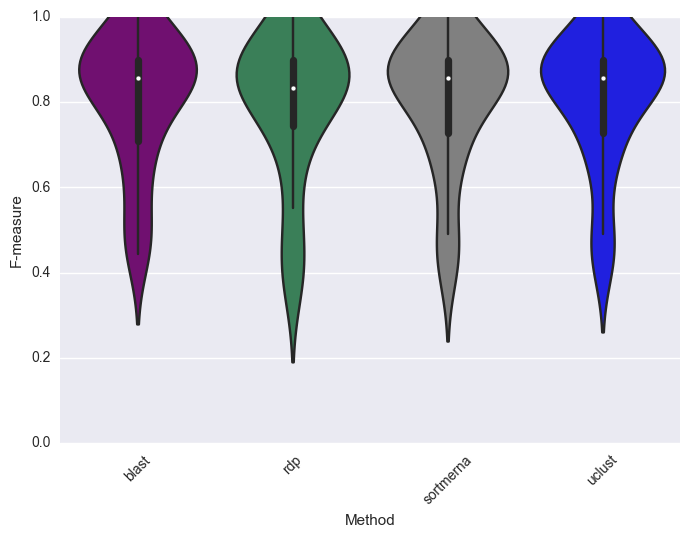

## gg_13_8_otus level 5

Method          Parameters  Precision    Recall  F-measure
3     uclust          0.76:0.9:1   0.694840  0.784455   0.728046
2  sortmerna  0.51:0.8:1:0.8:1.0   0.685706  0.775146   0.718076
0      blast               1e-10   0.683409  0.762547   0.712604
1        rdp                 0.0   0.665230  0.777616   0.706016

Method A   Method B         P
0      blast        rdp  0.254532
1      blast  sortmerna  0.154670
2      blast     uclust  0.121964
3        rdp  sortmerna  0.121964
4        rdp     uclust  0.001762
5  sortmerna     uclust  0.254532

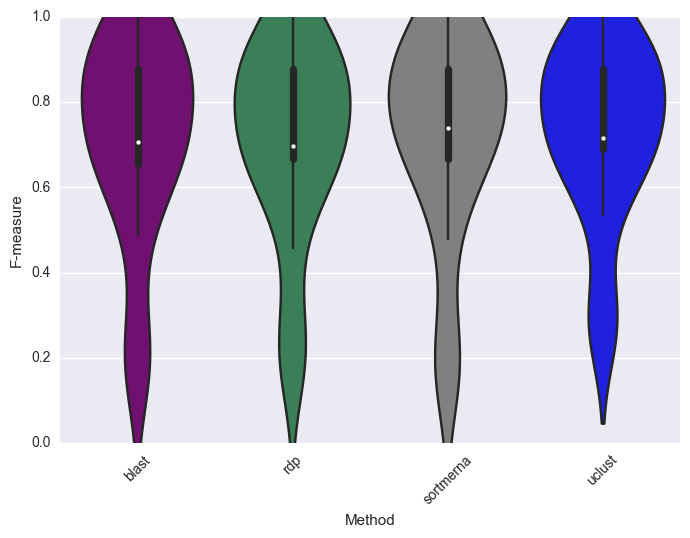

## gg_13_8_otus level 6

Method          Parameters  Precision    Recall  F-measure
0      blast               1e-10   0.347183  0.376220   0.356549
1        rdp                 0.0   0.336370  0.391378   0.356536
3     uclust          0.51:0.8:1   0.341974  0.382494   0.356018
2  sortmerna  0.76:0.9:1:0.8:1.0   0.344894  0.375077   0.354876

Method A   Method B         P
0      blast        rdp  0.996719
1      blast  sortmerna  0.749904
2      blast     uclust  0.996597
3        rdp  sortmerna  0.989701
4        rdp     uclust  0.996597
5  sortmerna     uclust  0.994859

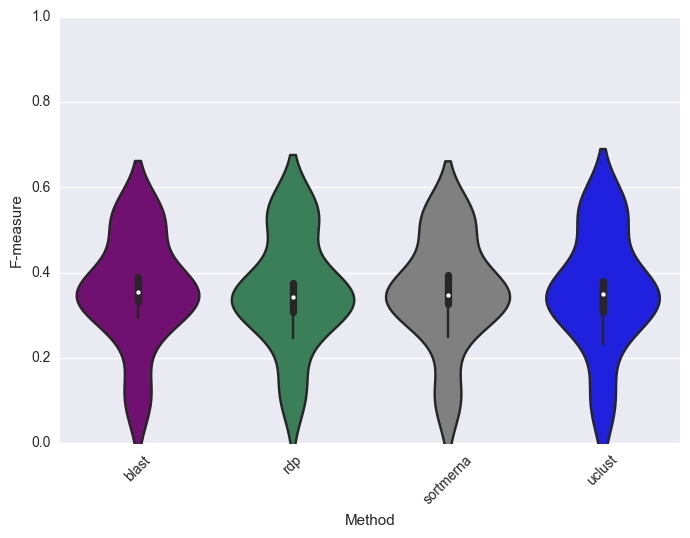

## unite_20.11.2016 level 4

Method          Parameters  Precision  Recall  F-measure
0      blast               0.001   0.826389     1.0   0.904167
1        rdp                 0.4   0.826389     1.0   0.904167
3     uclust          0.51:0.8:1   0.777778     1.0   0.875000
2  sortmerna  0.51:0.8:1:0.8:1.0   0.609848     1.0   0.757310

/Users/nbokulich/miniconda3/envs/qiime2-06/lib/python3.5/site-packages/statsmodels/stats/multitest.py:157: RuntimeWarning: invalid value encountered in greater
  notreject = pvals > alphacSidak_all
/Users/nbokulich/miniconda3/envs/qiime2-06/lib/python3.5/site-packages/statsmodels/stats/multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


Method A   Method B         P
0      blast        rdp       NaN
1      blast  sortmerna  0.000001
2      blast     uclust  0.210052
3        rdp  sortmerna  0.000001
4        rdp     uclust  0.210052
5  sortmerna     uclust  0.000203

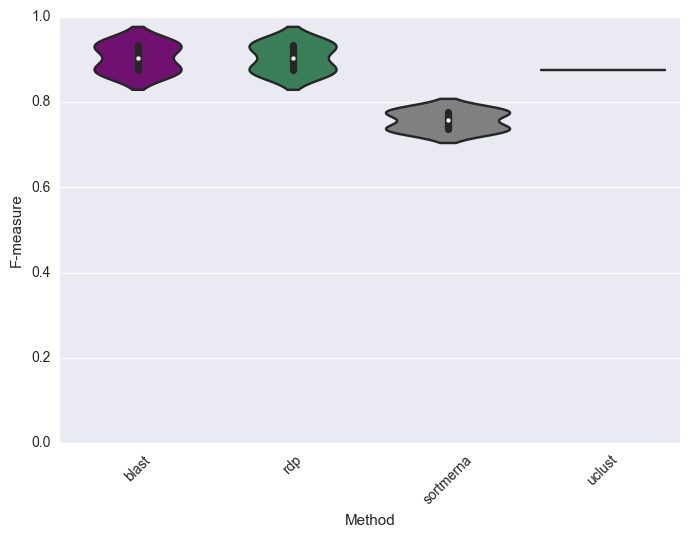

## unite_20.11.2016 level 5

Method          Parameters  Precision    Recall  F-measure
3     uclust          0.51:0.8:1   0.583333  0.777778   0.666667
0      blast               0.001   0.560897  0.777778   0.651515
1        rdp                 0.4   0.572727  0.666667   0.615789
2  sortmerna  0.51:0.8:1:0.8:1.0   0.483333  0.777778   0.596014

Method A   Method B             P
0      blast        rdp  3.696522e-09
1      blast  sortmerna  2.953341e-07
2      blast     uclust  7.558682e-02
3        rdp  sortmerna  1.236632e-04
4        rdp     uclust  1.604193e-03
5  sortmerna     uclust  1.772632e-04

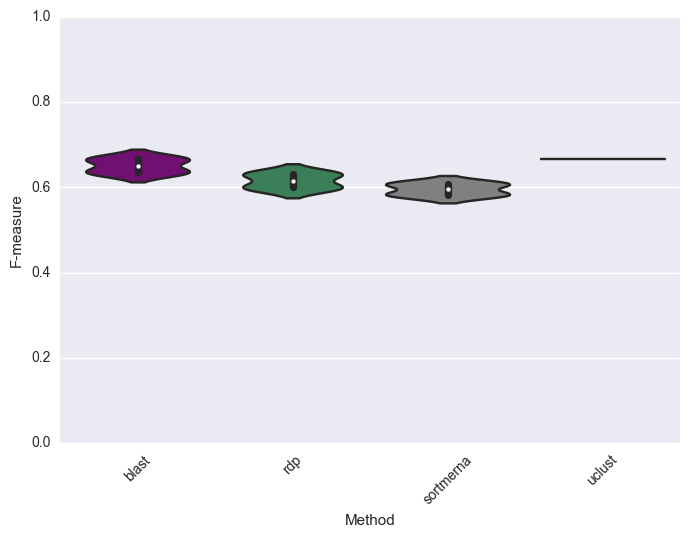

## unite_20.11.2016 level 6

Method          Parameters  Precision    Recall  F-measure
3     uclust          0.76:0.9:1   0.222222  0.166667   0.190476
1        rdp                 0.4   0.174242  0.166667   0.170290
0      blast               0.001   0.160256  0.166667   0.163333
2  sortmerna  0.76:0.9:1:0.8:1.0   0.153846  0.166667   0.160000

Method A   Method B             P
0      blast        rdp  2.124116e-07
1      blast  sortmerna  7.558682e-02
2      blast     uclust  3.673795e-05
3        rdp  sortmerna  2.857802e-03
4        rdp     uclust  1.772632e-04
5  sortmerna     uclust  0.000000e+00

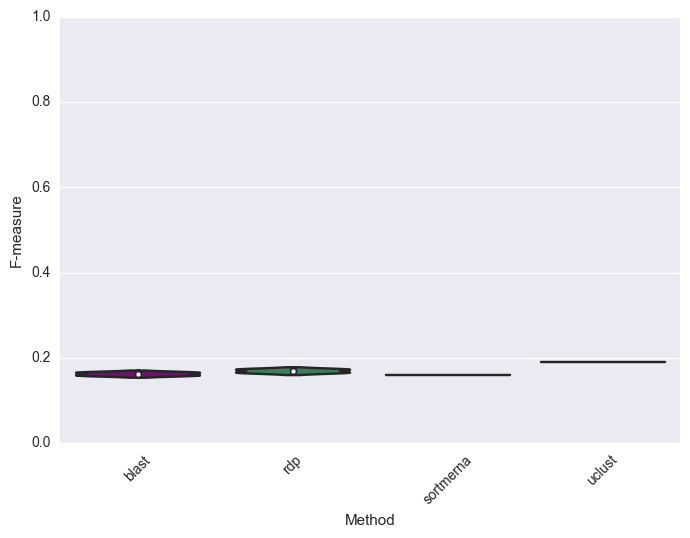

In [15]:
rank_optimized_method_performance_by_dataset(mock_results,
                                             dataset="Reference",
                                             metric="F-measure",
                                             level_range=range(4,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Precision",
                                                             "Recall",
                                                             "F-measure"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)

Evaluation 2: Compute and summarize correlations between observed and known mock community structure
----------------------------------------------------------------------------------------------------

In this evaluation, we compute and summarize the correlation between each result (pre-computed and query) and the known composition of the mock communities. We then summarize the results in two ways: first with a series of boxplots of correlation coefficients by method; and second with a table of the top methods based on their Pearson correlation coefficient. 

This is a quantitative evaluation, which tells us about the ability of the different methods to report the taxa that are present in each sample and accurately assess their abundance. Because many factors can affect the observed abundance of taxa beyond the accuracy of the taxonomic assigner (e.g., primer bias), the correlation coefficients are frequently low, but we expect that their relative values are informative in understanding which taxonomic assigners are more correct than others.

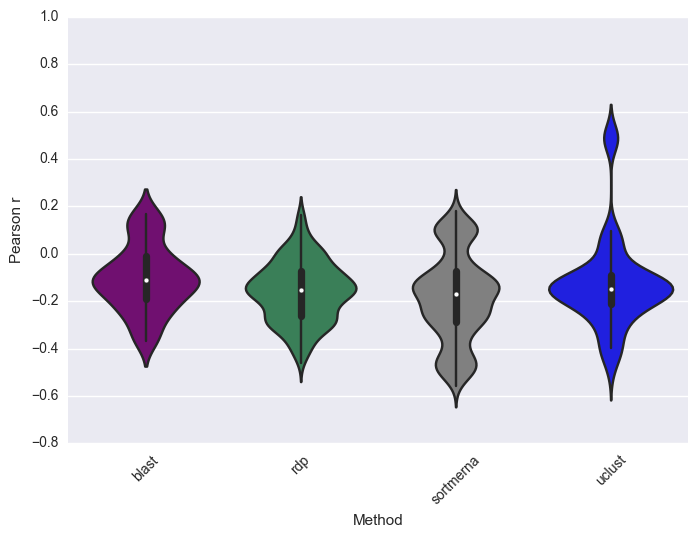

In [16]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Pearson r", y_min=None, color_pallette=color_pallette)

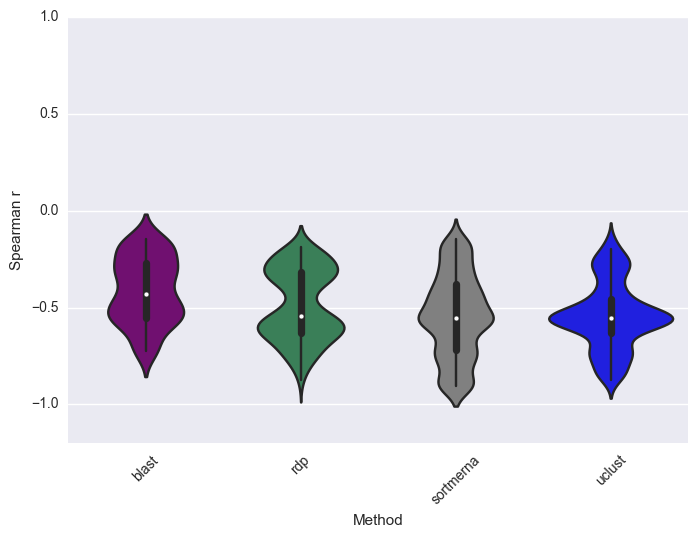

In [17]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Spearman r", y_min=None, color_pallette=color_pallette)

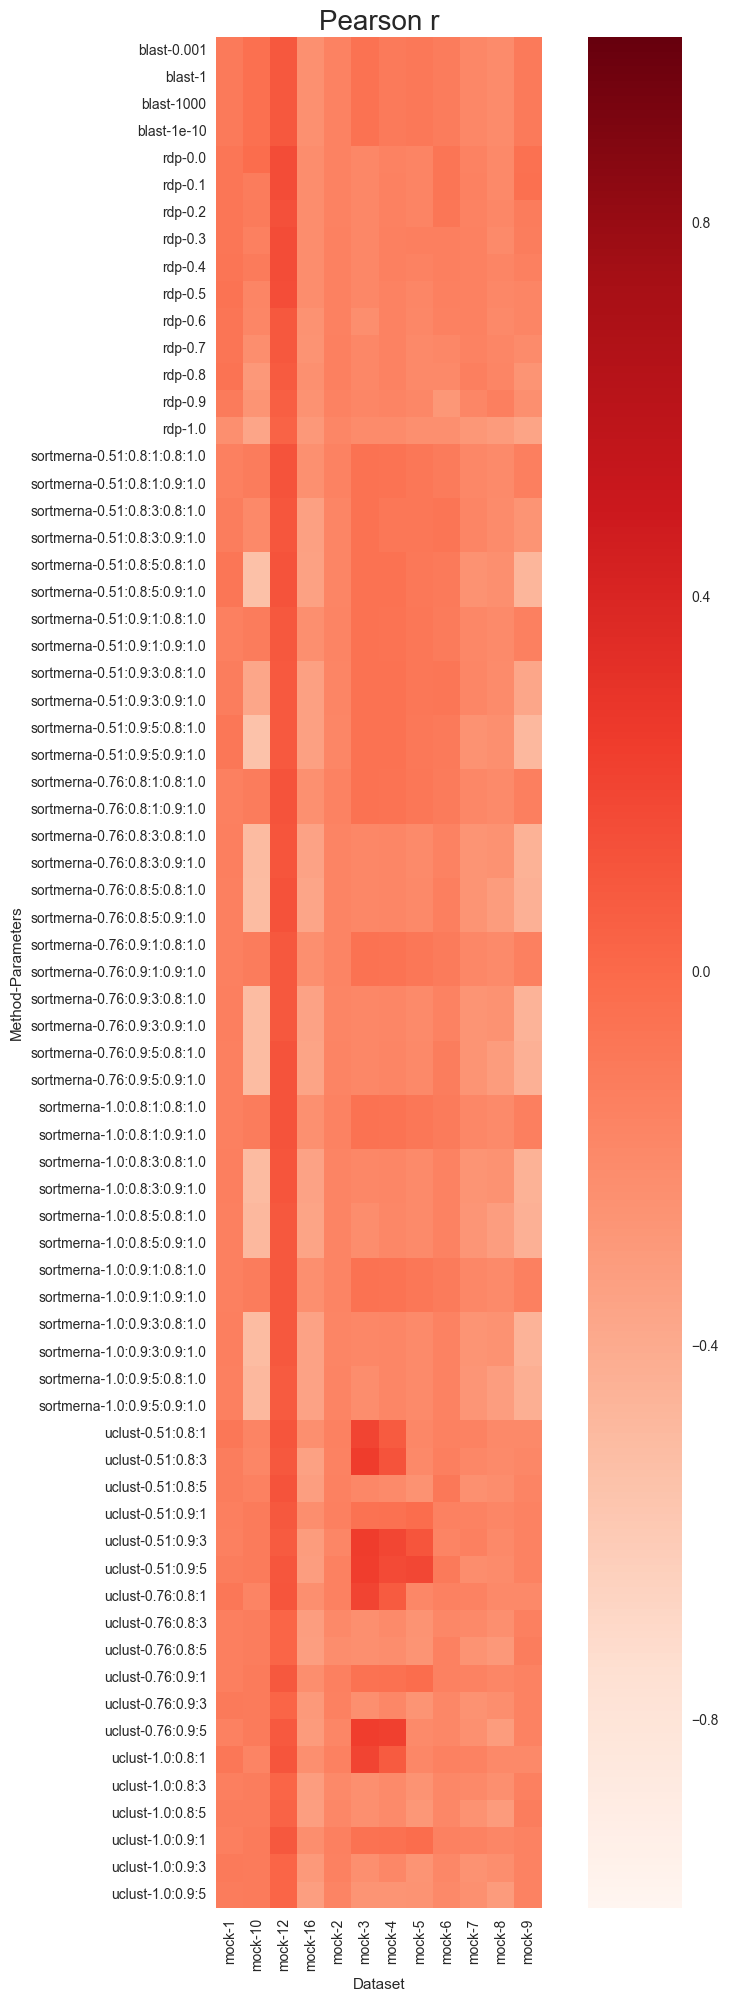

In [31]:
heatmap_from_data_frame(mock_results_6, "Pearson r", vmin=-1, vmax=1)

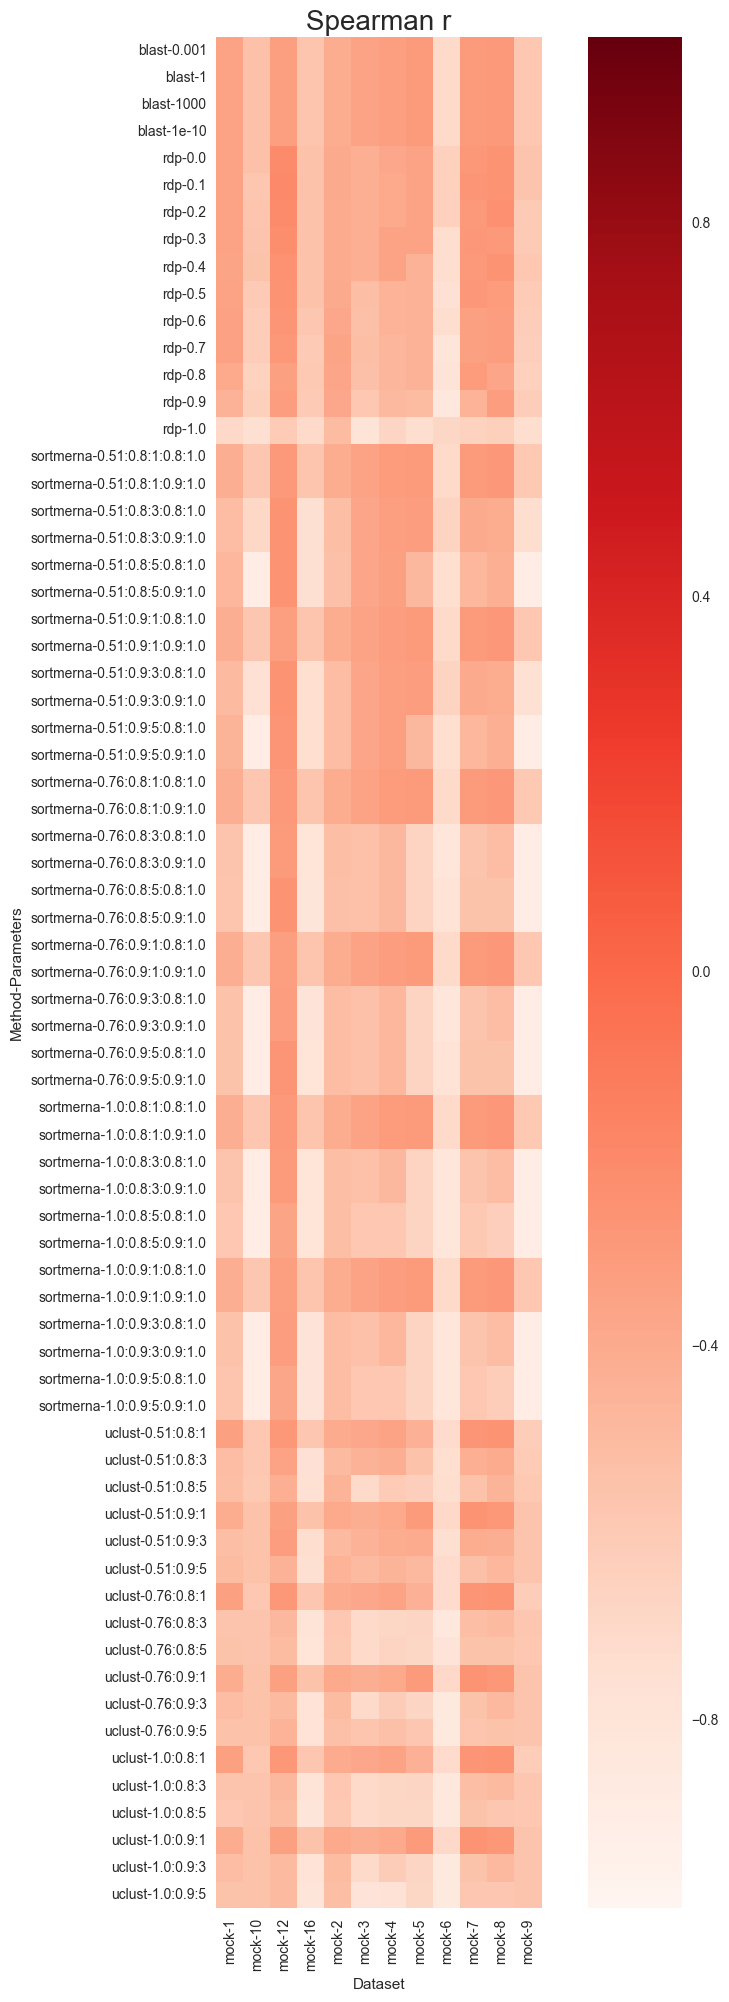

In [32]:
heatmap_from_data_frame(mock_results_6, "Spearman r", vmin=-1, vmax=1)

In [12]:
for i in [n for n in range(1,11)] + [12, 16]:
    display(Markdown('## mock-{0}'.format(i)))
    best = method_by_dataset_a2(mock_results_6, 'mock-{0}'.format(i))
    display(best)

## mock-1

Method          Parameters  Pearson r  Spearman r
49         rdp                 0.5  -0.058628   -0.349733
104  sortmerna  0.51:0.8:5:0.9:1.0  -0.076853   -0.469838
319     uclust           1.0:0.8:1  -0.078259   -0.335470
19       blast               1e-10  -0.100623   -0.349684

## mock-2

Method          Parameters  Pearson r  Spearman r
3169        rdp                 0.8  -0.134385   -0.360094
3439     uclust           1.0:0.9:1  -0.137530   -0.389475
3244  sortmerna  0.76:0.8:1:0.8:1.0  -0.152799   -0.409449
3109      blast               0.001  -0.152799   -0.409449

## mock-3

Method          Parameters  Pearson r  Spearman r
4569     uclust          0.51:0.9:3   0.483971   -0.250102
4129  sortmerna  0.76:0.9:1:0.8:1.0  -0.000922   -0.200305
3469      blast               0.001  -0.000922   -0.200305
3669        rdp                 0.6  -0.048563   -0.357890

## mock-4

Method          Parameters  Pearson r  Spearman r
6389     uclust          0.51:0.9:3   0.522213   -0.283083
5829  sortmerna  0.76:0.8:1:0.8:1.0   0.181348   -0.174494
5309      blast                   1   0.167218   -0.179842
5549        rdp                 0.9   0.094277   -0.363113

## mock-5

Method          Parameters  Pearson r  Spearman r
7789     uclust          0.51:0.9:5   0.502176   -0.389990
6709      blast                1000   0.117468   -0.166314
7029  sortmerna  0.51:0.8:3:0.9:1.0   0.109023   -0.171134
6929        rdp                 0.9   0.083755   -0.384576

## mock-6

Method          Parameters  Pearson r  Spearman r
8297  sortmerna  0.51:0.8:3:0.8:1.0  -0.055397   -0.647996
8117        rdp                 0.1  -0.056926   -0.640484
8837     uclust          0.51:0.8:5  -0.080642   -0.729887
8042      blast               0.001  -0.103005   -0.696262

## mock-7

Method          Parameters  Pearson r  Spearman r
9257        rdp                 0.8  -0.105845   -0.289796
9903     uclust          0.51:0.9:3  -0.116201   -0.388889
9332  sortmerna  0.51:0.8:3:0.8:1.0  -0.148125   -0.376386
9077      blast               0.001  -0.159849   -0.270484

## mock-8

Method         Parameters  Pearson r  Spearman r
10307        rdp                0.9  -0.118496   -0.305028
11103     uclust          1.0:0.9:1  -0.157266   -0.277441
10803  sortmerna  1.0:0.9:1:0.9:1.0  -0.178618   -0.282132
10113      blast              0.001  -0.182659   -0.283063

## mock-9

Method         Parameters  Pearson r  Spearman r
11208        rdp                0.0  -0.013854   -0.552881
11148      blast              0.001  -0.088475   -0.573749
12034     uclust         0.76:0.8:5  -0.103205   -0.536776
11749  sortmerna  1.0:0.8:1:0.9:1.0  -0.126393   -0.596489

## mock-10

Method          Parameters  Pearson r  Spearman r
417         rdp                 0.0   0.016503   -0.509773
387       blast                1000   0.000529   -0.509773
1333     uclust           1.0:0.8:5  -0.067815   -0.554392
673   sortmerna  0.51:0.9:1:0.8:1.0  -0.094590   -0.573749

## mock-12

Method          Parameters  Pearson r  Spearman r
1419        rdp                 0.3   0.162086   -0.212147
1539  sortmerna  0.76:0.8:5:0.8:1.0   0.130987   -0.257319
1649     uclust          0.51:0.8:5   0.122498   -0.424767
1389      blast                   1   0.097482   -0.326827

## mock-16

Method         Parameters  Pearson r  Spearman r
2804        rdp                0.4  -0.213182   -0.543847
3064     uclust         0.76:0.9:1  -0.223247   -0.546578
2994  sortmerna  1.0:0.9:1:0.9:1.0  -0.232249   -0.568120
2769      blast                  1  -0.240293   -0.567689

## gg_13_8_otus level 4

Method          Parameters  Pearson r  Spearman r  F-measure
3     uclust          0.51:0.9:3   0.364847    0.579517   0.798733
1        rdp                 0.5   0.366551    0.565920   0.777424
2  sortmerna  0.76:0.9:1:0.8:1.0   0.318977    0.552117   0.800696
0      blast               1e-10   0.326969    0.546378   0.802114

Method A   Method B         P
0      blast        rdp  0.656592
1      blast  sortmerna  0.656592
2      blast     uclust  0.045320
3        rdp  sortmerna  0.656592
4        rdp     uclust  0.656592
5  sortmerna     uclust  0.100013

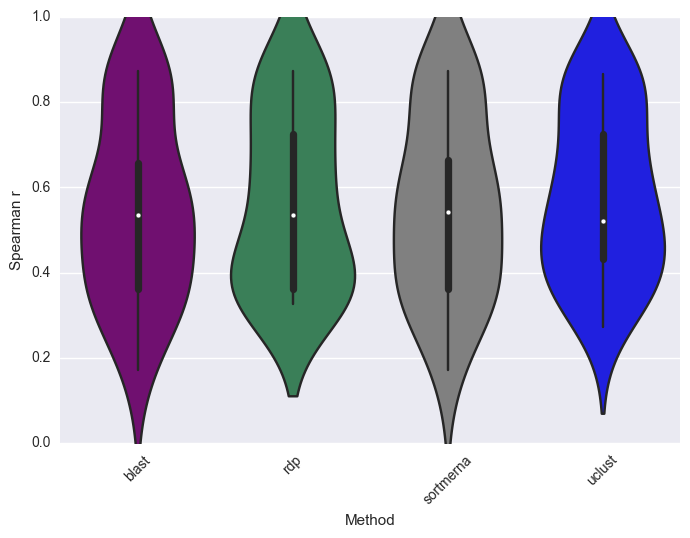

## gg_13_8_otus level 5

Method          Parameters  Pearson r  Spearman r  F-measure
3     uclust          0.76:0.9:1   0.278734    0.401479   0.728046
1        rdp                 0.2   0.249974    0.392333   0.703340
2  sortmerna  0.76:0.9:1:0.8:1.0   0.234878    0.357503   0.716533
0      blast               1e-10   0.241252    0.350734   0.712604

Method A   Method B         P
0      blast        rdp  0.006130
1      blast  sortmerna  0.293578
2      blast     uclust  0.013218
3        rdp  sortmerna  0.007011
4        rdp     uclust  0.464413
5  sortmerna     uclust  0.018593

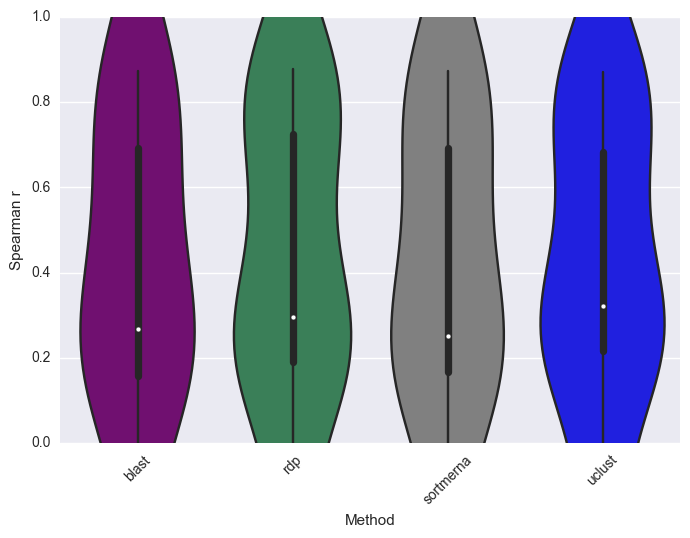

## gg_13_8_otus level 6

Method          Parameters  Pearson r  Spearman r  F-measure
2  sortmerna  0.51:0.8:1:0.8:1.0  -0.105175   -0.376509   0.352992
0      blast               0.001  -0.114284   -0.378452   0.356512
1        rdp                 0.1  -0.137758   -0.383760   0.355387
3     uclust          0.76:0.9:1  -0.090747   -0.392705   0.345876

Method A   Method B         P
0      blast        rdp  0.921989
1      blast  sortmerna  0.921989
2      blast     uclust  0.491421
3        rdp  sortmerna  0.921989
4        rdp     uclust  0.867613
5  sortmerna     uclust  0.450807

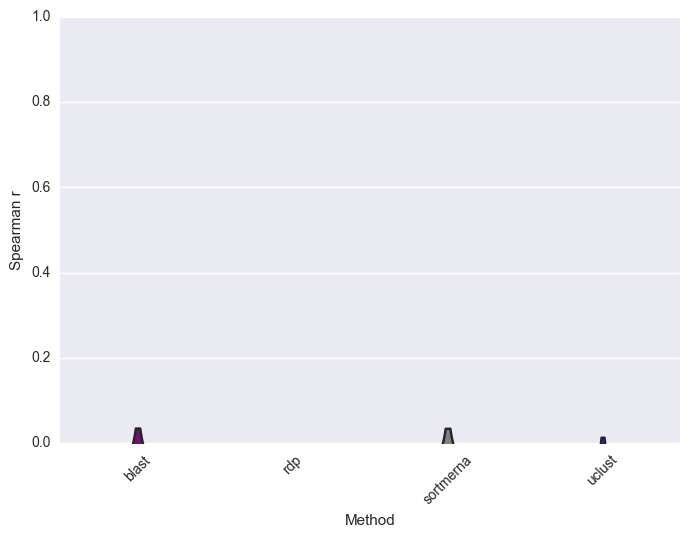

## unite_20.11.2016 level 4

Method          Parameters  Pearson r  Spearman r  F-measure
0      blast               0.001   0.302908    0.742876   0.904167
1        rdp                 0.0   0.396097    0.657639   0.848733
3     uclust           1.0:0.8:5   0.326131    0.426018   0.666667
2  sortmerna  0.51:0.8:1:0.8:1.0   0.135340    0.390908   0.757310

Method A   Method B         P
0      blast        rdp  0.338328
1      blast  sortmerna  0.000149
2      blast     uclust  0.000922
3        rdp  sortmerna  0.007208
4        rdp     uclust  0.079622
5  sortmerna     uclust  0.354232

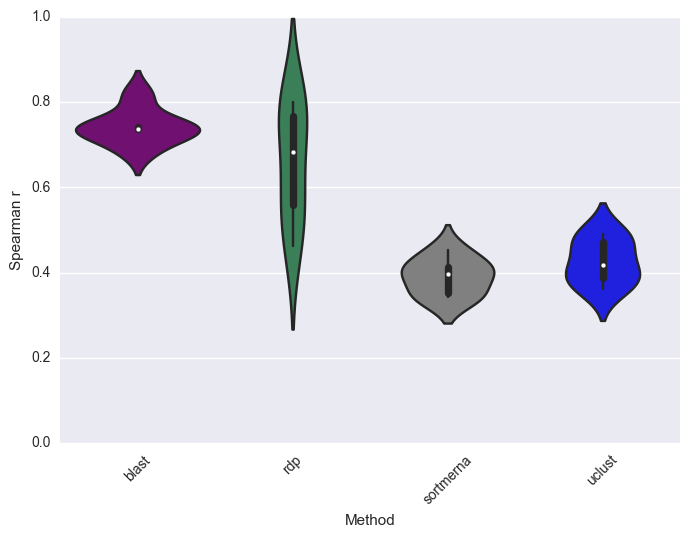

## unite_20.11.2016 level 5

Method          Parameters  Pearson r  Spearman r  F-measure
0      blast               0.001   0.364263    0.438631   0.651515
1        rdp                 0.0   0.380850    0.310346   0.557246
2  sortmerna  0.51:0.8:1:0.8:1.0   0.175088    0.239506   0.596014
3     uclust          0.76:0.9:1   0.207831    0.187811   0.555556

Method A   Method B         P
0      blast        rdp  0.000060
1      blast  sortmerna  0.001328
2      blast     uclust  0.000129
3        rdp  sortmerna  0.020465
4        rdp     uclust  0.003071
5  sortmerna     uclust  0.016451

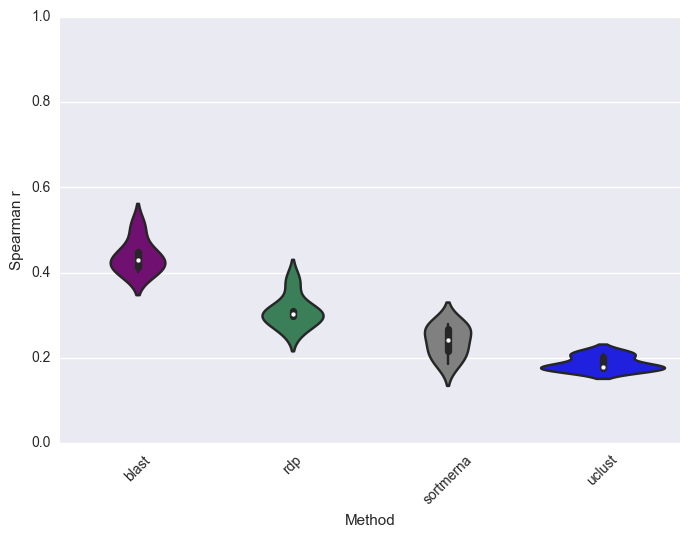

## unite_20.11.2016 level 6

Method          Parameters  Pearson r  Spearman r  F-measure
1        rdp                 0.0  -0.028401   -0.548747   0.156526
3     uclust          0.76:0.9:1  -0.128540   -0.550927   0.190476
0      blast               0.001  -0.066687   -0.559469   0.163333
2  sortmerna  0.76:0.9:1:0.8:1.0  -0.124671   -0.579000   0.160000

Method A   Method B         P
0      blast        rdp  0.272887
1      blast  sortmerna  0.476823
2      blast     uclust  0.618841
3        rdp  sortmerna  0.148725
4        rdp     uclust  0.785686
5  sortmerna     uclust  0.035280

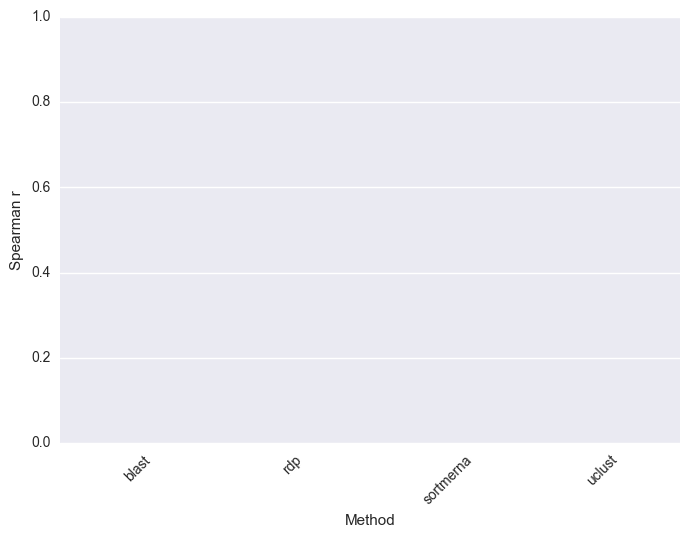

In [18]:
rank_optimized_method_performance_by_dataset(mock_results,
                                             dataset="Reference",
                                             metric="Spearman r",
                                             level_range=range(4,7),
                                             display_fields=["Method",
                                                             "Parameters",
                                                             "Pearson r",
                                                             "Spearman r",
                                                             "F-measure"],
                                             paired=True,
                                             parametric=True,
                                             color=None,
                                             color_pallette=color_pallette)